In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

Всё дельное начинается [тут](#1)

### Неудачный эксперимент с `pcolormesh`

In [ ]:
x, y = np.arange(0, 301), np.arange(0, 32)

In [ ]:
x.shape, y.shape

((301,), (32,))

In [ ]:
z = np.zeros((301, 32, 3))

In [ ]:
z.shape

(301, 32, 3)

In [ ]:
y

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
z[0:11, :] = np.array([247/255, 148/255, 181/255])
z[11:21, :] = np.array([245/255, 254/255, 133/255])
z[21:31, :] = np.array([0.41, 0.96, 0.32])

In [ ]:
z.shape

(301, 32, 3)

In [ ]:
y.shape, x.shape

((32,), (301,))

In [ ]:
np.swapaxes(z, 0, 1).shape

(32, 301, 3)

In [ ]:
np.meshgrid(x, y)[0].shape

(32, 301)

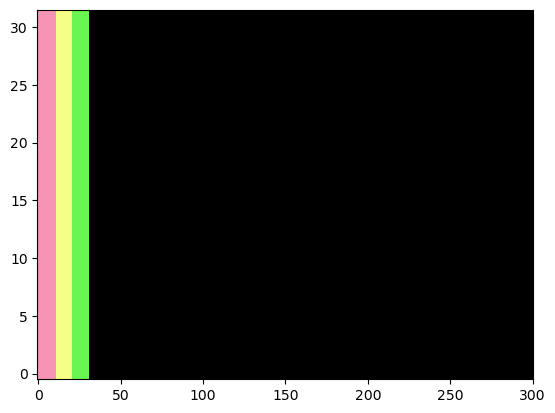

In [ ]:
plt.pcolormesh(x, y, np.swapaxes(z, 0, 1), shading='nearest')

Мда...

---

<a id=1></a>
# Quality scores across all bases

In [ ]:
!head /home/egerasimov/qc/boxplot.fastq

@SRR2968002.1 1 length=235
GAGCACTACCATGACGTCATTAAAGTAAAAGTTCCTTAATATTGCAATTTGCTTGAACGCATGCCACTTCAGAATATTTCGTACTTACACAGACCATACATTAGAATAATATGCCACATCACTGTCGTAACACTCTTTATTCACCGAGCAATAATACGGTAGTGGCTCGCACTCATGCGGGGGCTATGATACAATTGTACCCTATTTCCATTCTCATATGCTATCCGCAATGTCC
+
CCCCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGEGGGGGGGGGGGGGGGGGGGGGGGGGGGFGGGGGGGGGGGGGGGGFFGFGGGGGGGGEGGGGGGGGGGGGGCGCBGGGGGDEG*::F
@SRR2968002.2 2 length=202
ATCATAGCCCCCGCATGAGTGCGAGCCACTACCGTATTATTGCTCGGTGAATAAAGAGTGTTACGACAGTGATGTGGCATATTATTCTAATGTATGGTCTGTGTAAGTACGAAATATTCTGAAGTGGCATGCGTTCAAGCAAATTGCAATATTAAGGAACTTTTACTTTAATGACGTCATGGTAGTGCTCGTACTTCAAGTC
+
CCCCCGGGFFEGGGGGEGGFGGGGCGGGFGGGGGDFGGGGGFGCFGGGGGGGFFGGGGCCEFGGECEGGGGGFGFFFGFGGGGGGGGGFGGFGFGGGFFCFGFGGGGGGGGGGGGGGGGGGGGFGFGGGGGGGGGGGGGGCGGGGGGGGGGFGGGFDFGGGGGGGGGGGGGGGGGD>BGGGGCEE=FGGGGGGGGGGGFGGG
@SRR2968002.3 3 length=165
GTGCGAGCCACTACCGTATTATTGCTCGGTGAATAAA

In [ ]:
def read_fastq(path):
    """
    return generator of fastq entries, that yields 4 lines each
    """
    with open(path, 'r') as f:
        temp = []
        for i, line in enumerate(f):
            temp.append(line)
            if (i + 1) % 4 == 0:
                entry = temp
                temp = []
                yield entry

Тут я решил попробовать функцию-генератор, чтобы не хранить весь fastq в памяти  
Интересно, насколько это оправдано и верно реализовано

In [ ]:
def transpose(mtx):
    """
    transpose irregular list if list
    (with different lengths of rows)
    используется чтобы от списка с ридами перейти к списку с позициями
    Пример:
    >>>transpose([[1, 2, 3], [4], [5, 6]])
    >>>[[1, 4, 5], [2, 6], [3]]
    """
    mtx = [list(i) for i in(itertools.zip_longest(*mtx))]
    mtx = [[i for i in row if i is not None] for row in mtx]
    return mtx

In [ ]:
def get_qualities(path):
    """
    Прочитать качество ридов из файла fastq
    Перевести ascII33 -> int
    """
    reads = read_fastq(path)
    quality = [i[3].rstrip('\n') for i in reads]
    quality = [list(i) for i in quality]
    quality = [[ord(i) - 33 for i in row]
               for row in quality]
    quality = transpose(quality)
    return quality

In [ ]:
def submerge(mtx, n):
    """
    объединяет n нуклеотидов в один список(объединять боксы для нескольких нуклеотидов)
    Пример:
    >>>submerge([[1, 1], [2], [3, 3, 3], [4, 4], [5, 5, 5], [6]], n=3)
    >>>[[1, 1, 2, 3, 3, 3], [4, 4, 5, 5, 5, 6]]
    """
    N = len(mtx)
    new = []
    for i in range(0, N, n):
        grp = [q for row in mtx[i:i+n] for q in row]
        new.append(grp)
    return new

In [ ]:
submerge([[1, 1], [2], [3, 3, 3], [4, 4], [5, 5, 5], [6]], n=3)

[[1, 1, 2, 3, 3, 3], [4, 4, 5, 5, 5, 6]]

In [ ]:
q = get_qualities('boxplot.fastq')
print(q)
q1 = submerge(q, 5)
print(q1)
q_means = [np.mean(i) for i in q1]
print(len(q_means))

[[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 32, 34, 34, 34, 34, 33, 34, 31, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 27, 34, 34, 34, 34, 34, 34, 32, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 23, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 21, 34, 34, 31, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 32, 34, 34, 34, 34, 34, 34, 34, 34, 32, 34, 34, 34

<ipython-input-7-b31767f3d346>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize': 12})


Text(0.5, 1.0, 'Quality scores across all bases')

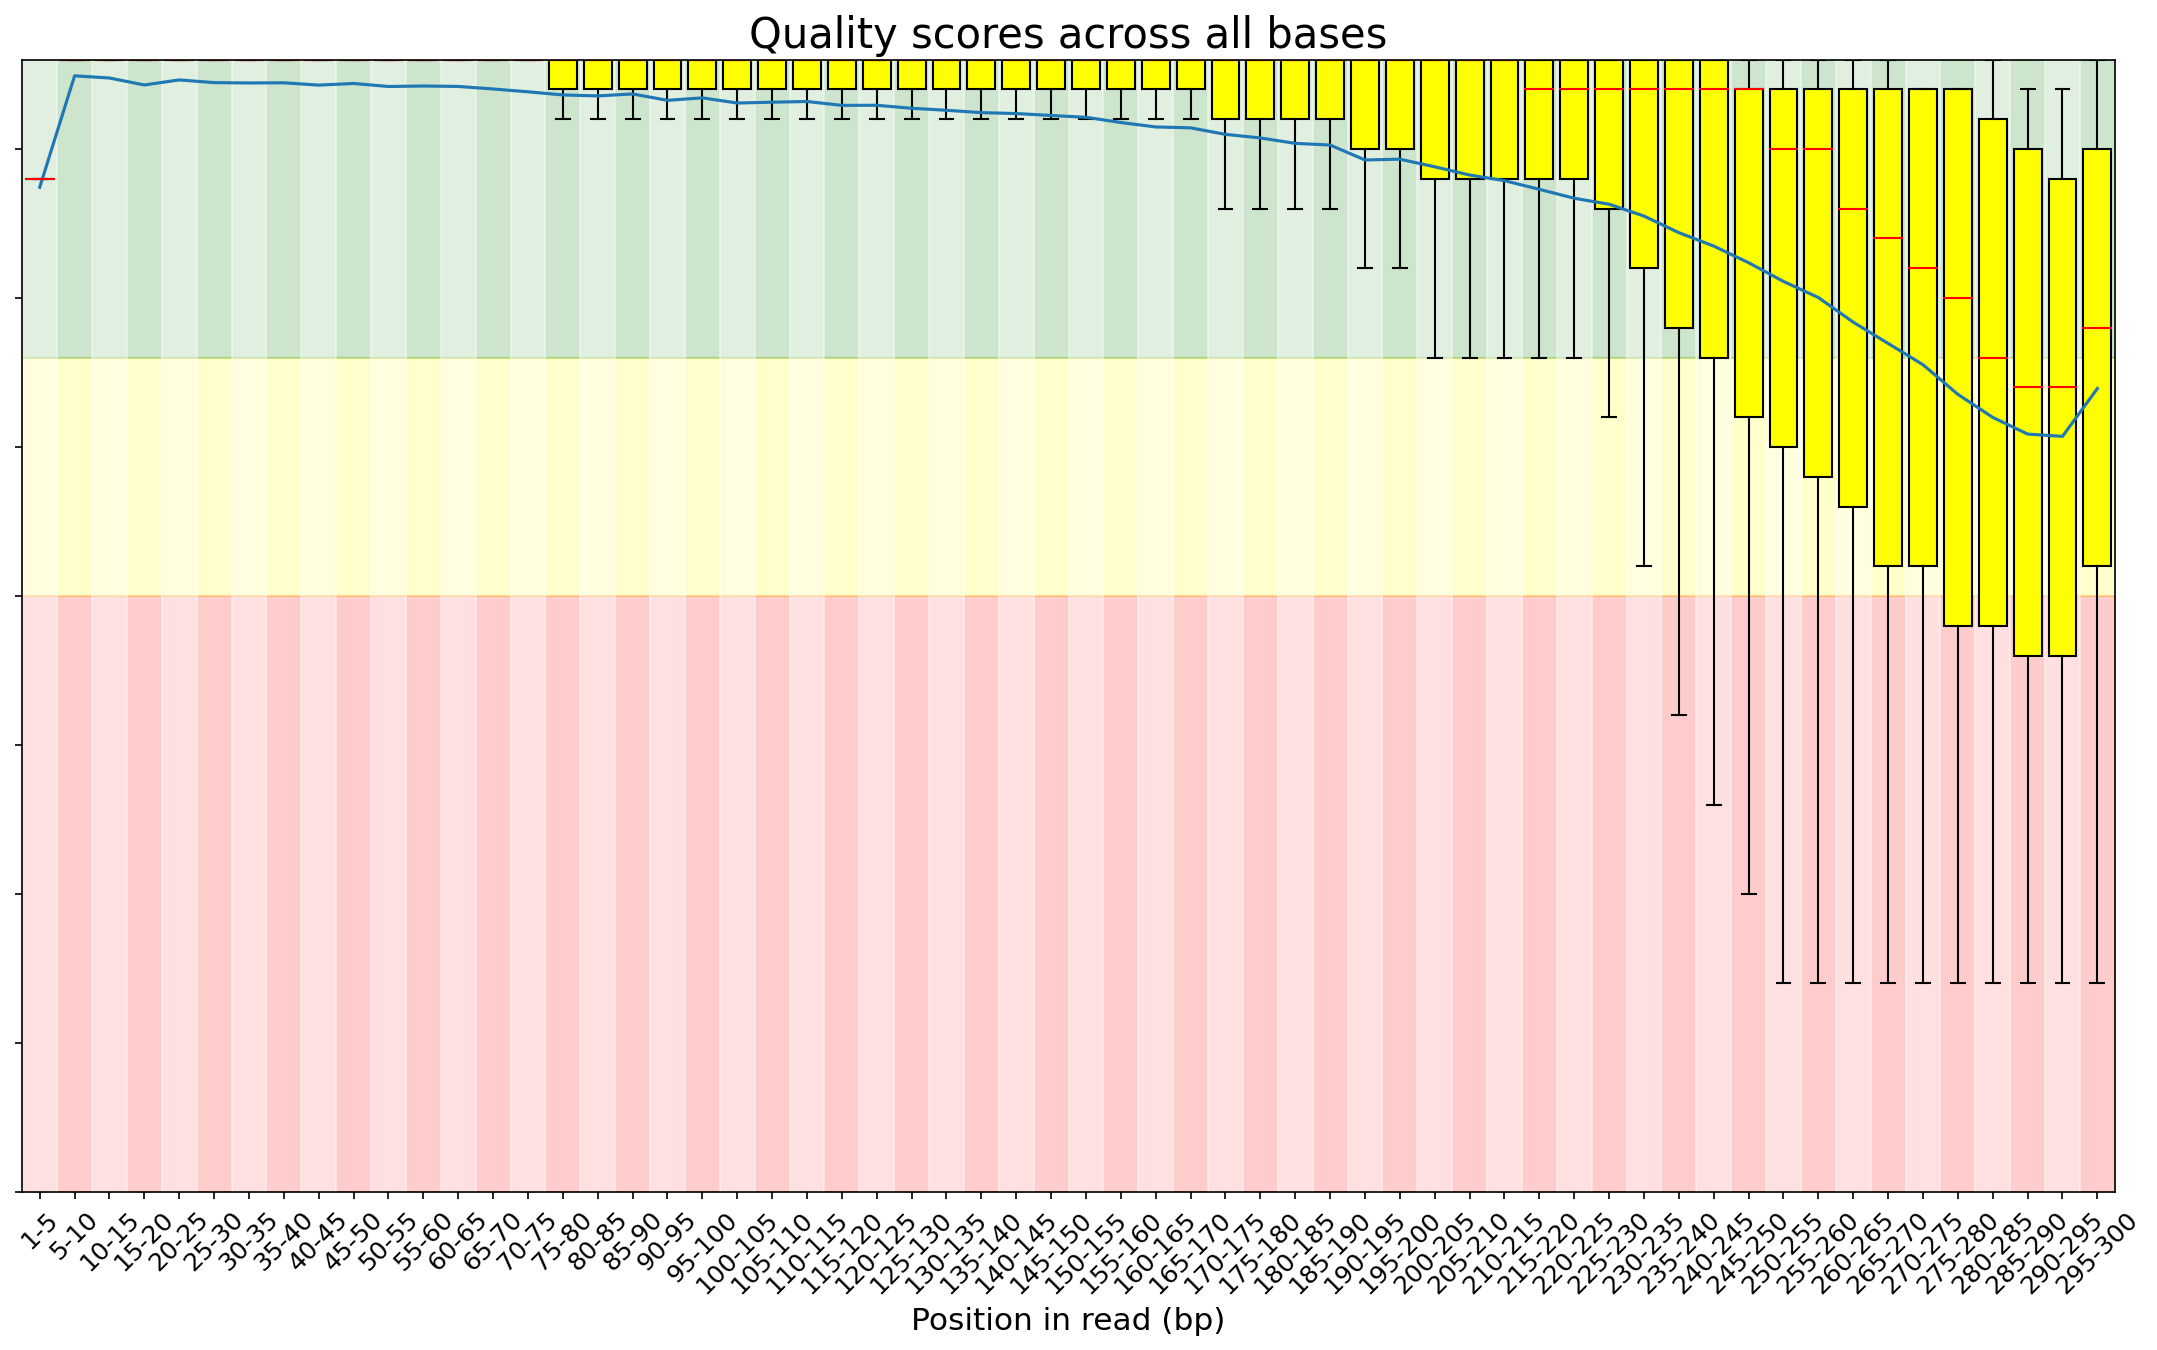

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10), dpi=150)

# background
ax.fill_between([0, 61], 0, 20, color='red', alpha=.2)
ax.fill_between([0, 61], 20, 28, color='yellow', alpha=.2)
ax.fill_between([0, 61], 28, 38, color='green', alpha=.2)
ax.set_xlim([0.5, 60.5])
ax.set_ylim([0, 38])
for i in range(0, 61):
    if i % 2 == 0:
        ax.axvspan(i+0.5, i+1.5, alpha=.4, color='white')

# boxplot
bp = ax.boxplot(q1, showfliers=False, widths = 0.8, patch_artist=True)
for box in bp['boxes']:
    box.set(facecolor='yellow')
plt.setp(bp['medians'], color='red')

    # lineplot
ax.plot(np.arange(1, 61, 1), q_means)

#ticklabels
labels = [f"{i}-{i+5}" for i in range(0, 299, 5)]
labels[0] = '1-5'
ax.set_xticklabels(labels, rotation = 45, fontdict={'fontsize': 12})
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize': 12})

ax.set_xlabel('Position in read (bp)', fontsize=15)
ax.set_title('Quality scores across all bases', fontsize=20)

## GC content

In [ ]:
def gc_count(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

1000


Text(0.5, 1.0, 'GC distribution over all sequences')

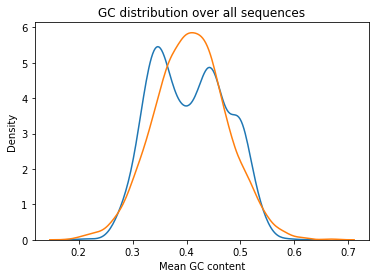

In [ ]:
np.random.seed(42)

reads = read_fastq('boxplot.fastq')
seqs = [i[1].rstrip('\n') for i in reads]
gc_count_list = [gc_count(i) for i in seqs]

print(len(gc_count_list))

# нормальное распределение
mu = np.mean(gc_count_list)
std = np.std(gc_count_list)
norm = np.random.normal(mu, std, 3000)

# рисуем
fig, ax = plt.subplots()
sns.kdeplot(gc_count_list)
sns.kdeplot(norm) # нормальное как-то не очень
ax.set_xlabel('Mean GC content')
ax.set_title('GC distribution over all sequences')

https://anton-granik.medium.com/fitting-and-visualizing-a-negative-binomial-distribution-in-python-3cc27fbc7ecf  
попробовать вот это

In [ ]:
mu = np.mean(gc_count_list)
sigma_sqr = np.var(gc_count_list)

n = mu**2 / (sigma_sqr - mu)
p = mu / sigma_sqr

In [ ]:
n

-0.41006610068929966

In [ ]:
from scipy.stats import nbinom
nb = nbinom.rvs(n, p, loc=0, size=300, random_state=42)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.nbinom` documentation for details.

Ладно

# Nucleotide content

In [ ]:
reads = read_fastq('boxplot.fastq')
seqs = [i[1].rstrip('\n') for i in reads]
seqs = [list(i) for i in seqs]
seqs_t = transpose(seqs)

print(seqs_t)

[['G', 'A', 'G', 'C', 'T', 'G', 'G', 'G', 'T', 'A', 'G', 'C', 'A', 'G', 'C', 'C', 'G', 'T', 'T', 'G', 'A', 'G', 'A', 'G', 'A', 'C', 'A', 'A', 'G', 'C', 'G', 'G', 'T', 'G', 'T', 'T', 'G', 'T', 'G', 'T', 'C', 'G', 'G', 'G', 'A', 'G', 'A', 'A', 'G', 'G', 'C', 'A', 'T', 'A', 'A', 'G', 'A', 'G', 'G', 'G', 'C', 'G', 'A', 'C', 'G', 'C', 'G', 'T', 'T', 'G', 'G', 'T', 'C', 'C', 'G', 'A', 'C', 'T', 'C', 'A', 'G', 'C', 'G', 'C', 'T', 'G', 'C', 'G', 'T', 'G', 'T', 'G', 'T', 'G', 'G', 'T', 'A', 'A', 'G', 'G', 'G', 'G', 'A', 'T', 'G', 'G', 'G', 'T', 'G', 'A', 'C', 'A', 'G', 'G', 'G', 'G', 'C', 'A', 'A', 'C', 'A', 'C', 'T', 'G', 'C', 'G', 'C', 'G', 'C', 'G', 'G', 'A', 'G', 'G', 'G', 'G', 'T', 'C', 'G', 'G', 'T', 'C', 'G', 'G', 'A', 'C', 'A', 'A', 'G', 'T', 'C', 'T', 'C', 'G', 'A', 'T', 'A', 'A', 'G', 'G', 'A', 'A', 'C', 'A', 'T', 'A', 'C', 'A', 'G', 'T', 'G', 'T', 'G', 'C', 'A', 'T', 'A', 'A', 'G', 'T', 'A', 'G', 'A', 'A', 'T', 'C', 'A', 'C', 'A', 'A', 'G', 'G', 'T', 'G', 'A', 'G', 'A', 'A', 'A', 'A'

In [ ]:
# тут не учитываются N и прочие символы из unicode, но для простоты забью на них
def count_bases(seq):
    cnt = {}
    len_seq = len(seq)
    for base in "ATGC":
        cnt[base] = seq.count(base) / len_seq
        print(base, seq.count(base))
    return cnt

In [ ]:
count_bases(seqs_t)

A 0
T 0
G 0
C 0


{'A': 0.0, 'T': 0.0, 'G': 0.0, 'C': 0.0}

In [ ]:
seqs_t_gc = [count_bases(i) for i in seqs_t]

print(seqs_t_gc)

A 235
T 159
G 382
C 224
A 231
T 425
G 149
C 195
A 285
T 345
G 170
C 199
A 186
T 411
G 133
C 270
A 390
T 388
G 107
C 115
A 441
T 193
G 256
C 110
A 329
T 271
G 224
C 176
A 416
T 244
G 181
C 159
A 186
T 261
G 215
C 338
A 318
T 348
G 115
C 219
A 249
T 289
G 318
C 144
A 276
T 330
G 209
C 185
A 236
T 282
G 247
C 235
A 235
T 272
G 194
C 299
A 328
T 243
G 218
C 211
A 332
T 296
G 185
C 187
A 315
T 293
G 192
C 200
A 322
T 293
G 193
C 192
A 313
T 310
G 172
C 205
A 291
T 298
G 204
C 207
A 323
T 280
G 207
C 190
A 271
T 302
G 191
C 236
A 320
T 291
G 204
C 185
A 319
T 274
G 212
C 195
A 282
T 298
G 199
C 221
A 329
T 301
G 192
C 178
A 295
T 295
G 236
C 174
A 294
T 299
G 215
C 192
A 309
T 278
G 200
C 213
A 301
T 298
G 203
C 198
A 302
T 292
G 202
C 204
A 300
T 299
G 208
C 193
A 306
T 286
G 228
C 180
A 312
T 268
G 210
C 210
A 297
T 299
G 182
C 222
A 316
T 306
G 192
C 186
A 297
T 277
G 209
C 217
A 303
T 292
G 207
C 198
A 332
T 268
G 196
C 204
A 290
T 311
G 191
C 208
A 292
T 286
G 210
C 212
A 307
T 298
G 20

In [ ]:
seqs_t_gc[0:10]

[{'A': 0.235, 'T': 0.159, 'G': 0.382, 'C': 0.224},
 {'A': 0.231, 'T': 0.425, 'G': 0.149, 'C': 0.195},
 {'A': 0.285, 'T': 0.345, 'G': 0.17, 'C': 0.199},
 {'A': 0.186, 'T': 0.411, 'G': 0.133, 'C': 0.27},
 {'A': 0.39, 'T': 0.388, 'G': 0.107, 'C': 0.115},
 {'A': 0.441, 'T': 0.193, 'G': 0.256, 'C': 0.11},
 {'A': 0.329, 'T': 0.271, 'G': 0.224, 'C': 0.176},
 {'A': 0.416, 'T': 0.244, 'G': 0.181, 'C': 0.159},
 {'A': 0.186, 'T': 0.261, 'G': 0.215, 'C': 0.338},
 {'A': 0.318, 'T': 0.348, 'G': 0.115, 'C': 0.219}]

In [ ]:
def get_base_gc(df, base):
    lst = []
    for i in seqs_t_gc:
        lst.append(i[base])
    print(lst)
    return lst

[0.235, 0.231, 0.285, 0.186, 0.39, 0.441, 0.329, 0.416, 0.186, 0.318, 0.249, 0.276, 0.236, 0.235, 0.328, 0.332, 0.315, 0.322, 0.313, 0.291, 0.323, 0.271, 0.32, 0.319, 0.282, 0.329, 0.295, 0.294, 0.309, 0.301, 0.302, 0.3, 0.306, 0.312, 0.297, 0.316, 0.297, 0.303, 0.332, 0.29, 0.292, 0.307, 0.31, 0.313, 0.309, 0.288, 0.281, 0.319, 0.295, 0.281, 0.301, 0.288, 0.304, 0.3, 0.28, 0.296, 0.31, 0.295, 0.297, 0.314, 0.284, 0.329, 0.278, 0.296, 0.274, 0.309, 0.302, 0.303, 0.32, 0.312, 0.315, 0.312, 0.282, 0.29, 0.3, 0.311, 0.267, 0.278, 0.289, 0.304, 0.278, 0.283, 0.281, 0.283, 0.276, 0.294, 0.285, 0.287, 0.283, 0.305, 0.269, 0.319, 0.308, 0.285, 0.301, 0.291, 0.269, 0.29, 0.295, 0.293, 0.305, 0.2602602602602603, 0.2772772772772773, 0.2982982982982983, 0.2925851703406814, 0.3039117352056169, 0.3229689067201605, 0.28986960882647944, 0.2597793380140421, 0.2868605817452357, 0.286144578313253, 0.2761044176706827, 0.3152610441767068, 0.2994974874371859, 0.26961770623742454, 0.3148893360160966, 0.2887

Text(0.5, 1.0, 'Sequence content across all bases')

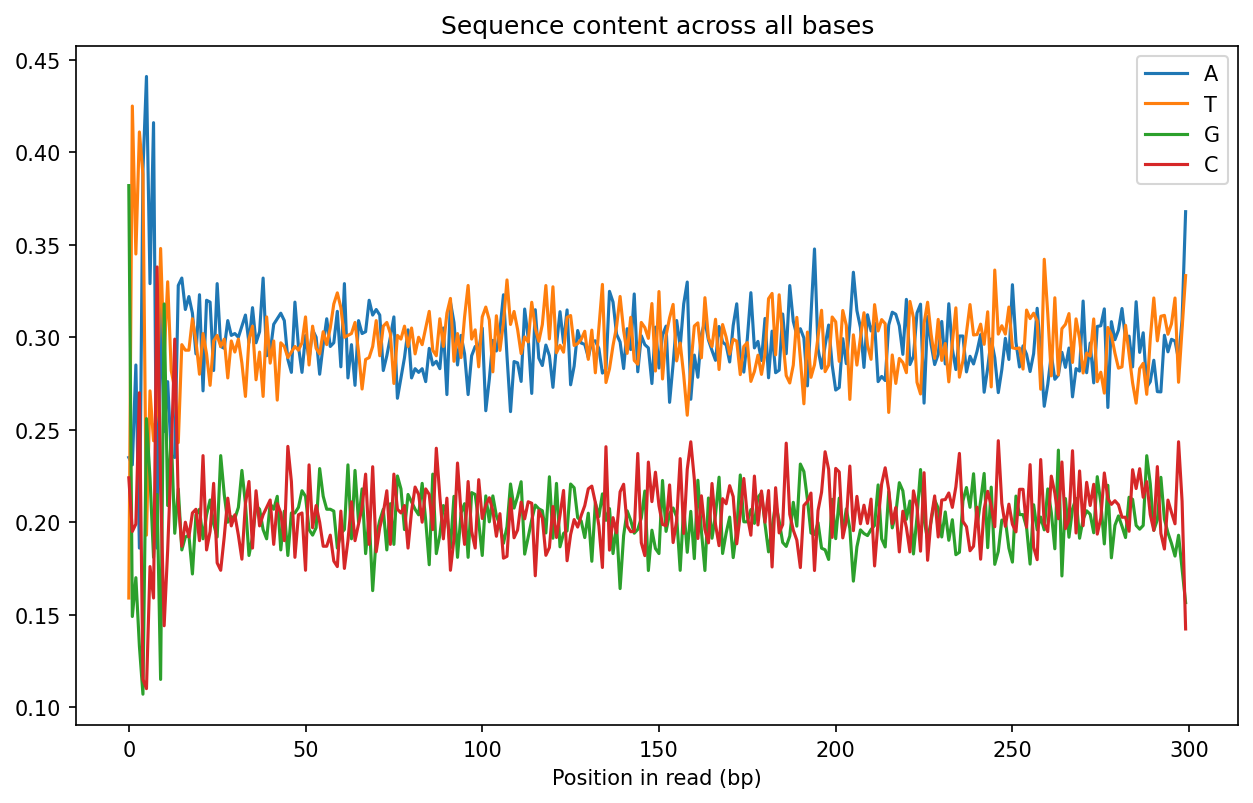

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ax.plot(get_base_gc(seqs_t_gc, 'A'), label='A')
ax.plot(get_base_gc(seqs_t_gc, 'T'), label='T')
ax.plot(get_base_gc(seqs_t_gc, 'G'), label='G')
ax.plot(get_base_gc(seqs_t_gc, 'C'), label='C')

ax.legend()
ax.set_xlabel('Position in read (bp)')
ax.set_title('Sequence content across all bases')

In [ ]:
def smooth_lst(lst, window):
    """
    сглаживает значения в списке скользящим окном
    """
    lst = pd.Series(lst)
    return lst.rolling(window=window).mean()

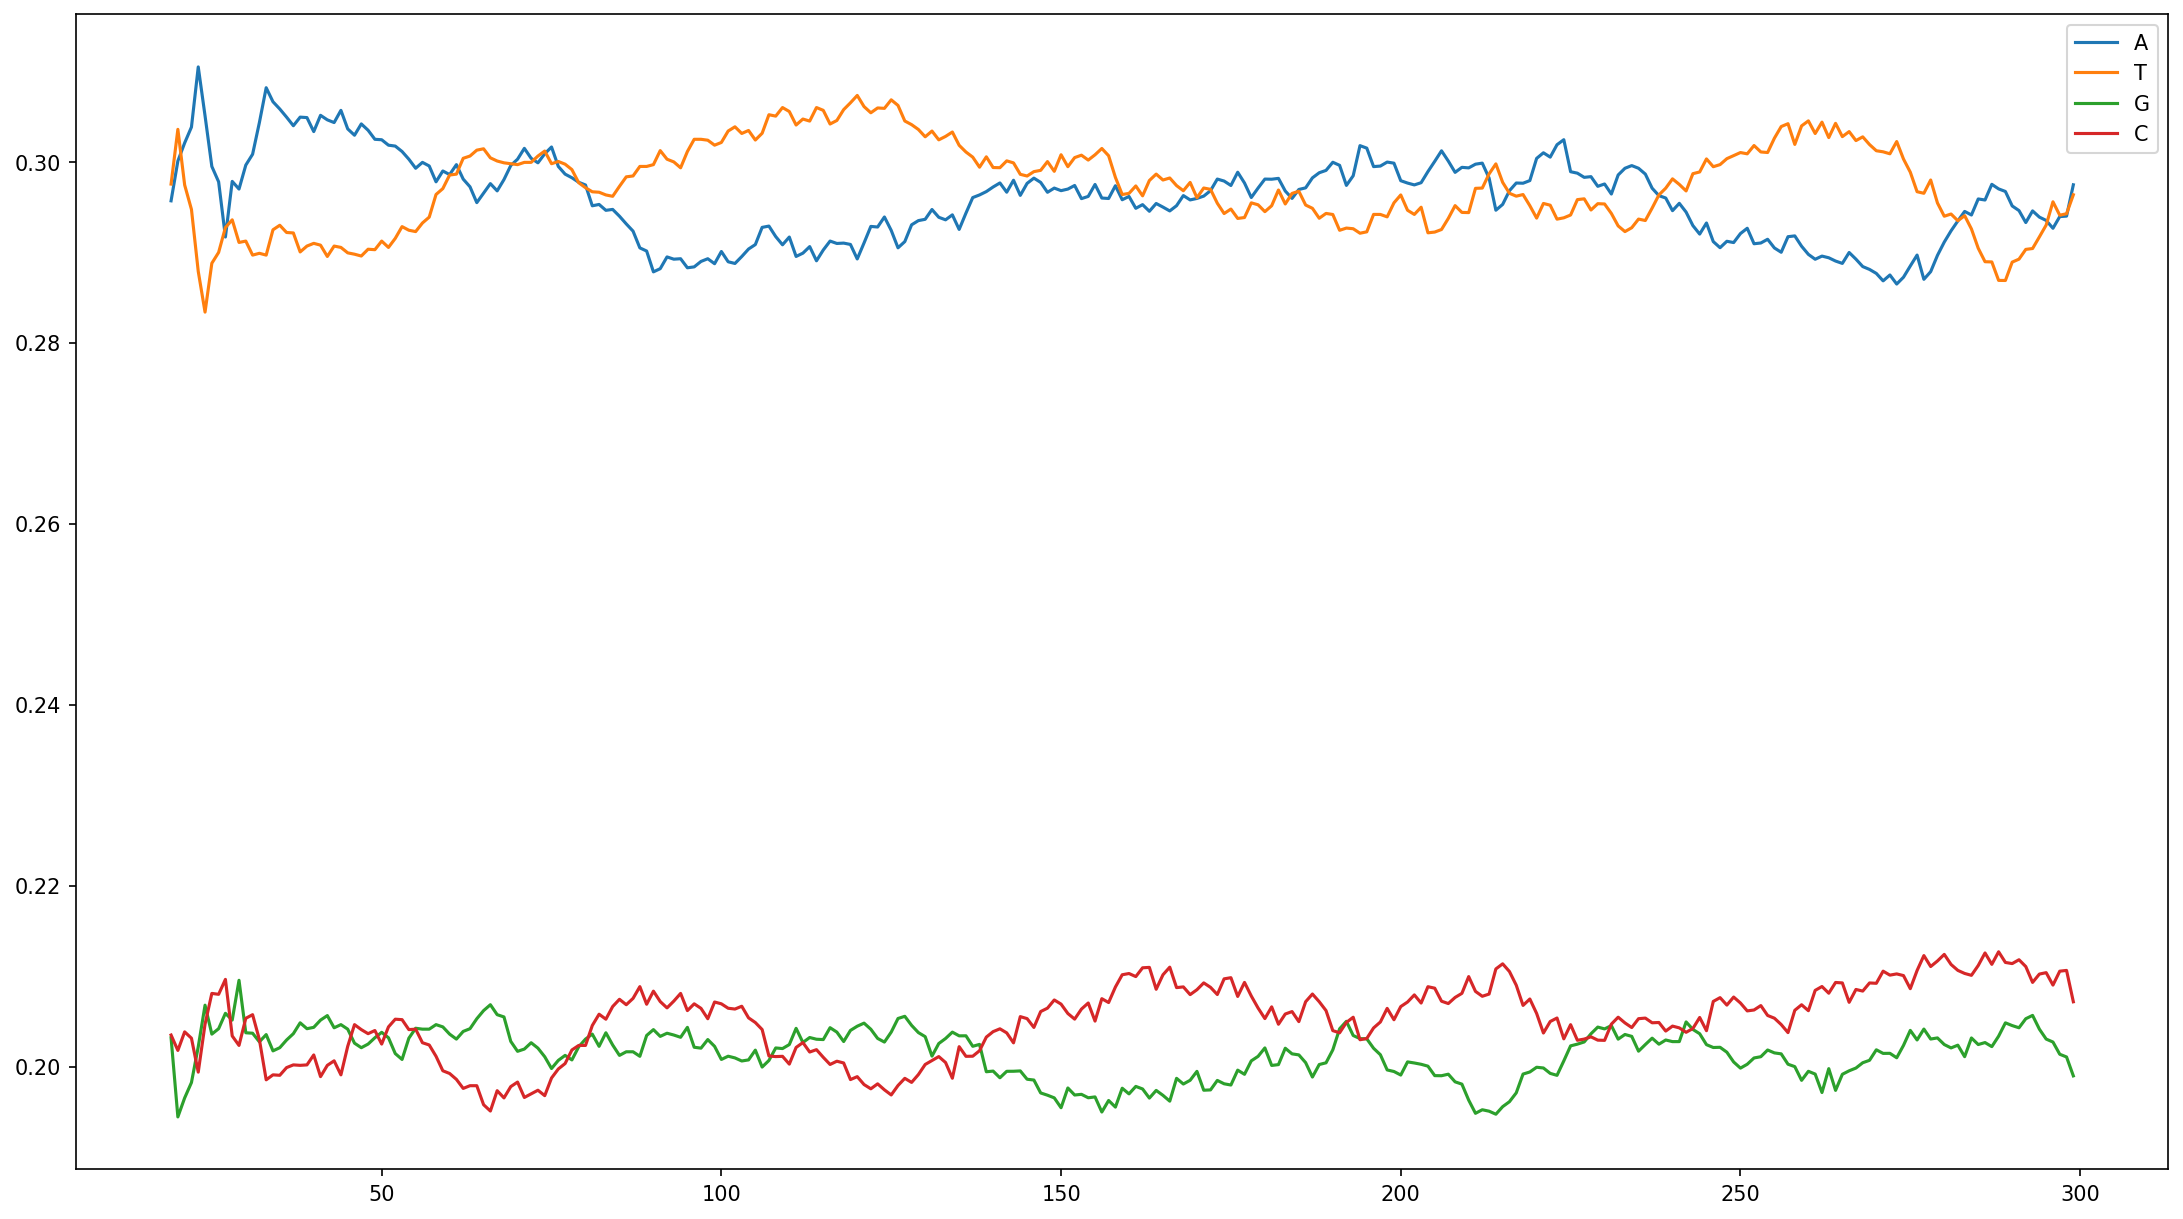

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10), dpi=150)

ax.plot(smooth_lst(get_base_gc(seqs_t_gc, 'A'), 20), label='A')
ax.plot(smooth_lst(get_base_gc(seqs_t_gc, 'T'), 20), label='T')
ax.plot(smooth_lst(get_base_gc(seqs_t_gc, 'G'), 20), label='G')
ax.plot(smooth_lst(get_base_gc(seqs_t_gc, 'C'), 20), label='C')

ax.legend()

Не очень

# Sequence len distribution

Text(0.5, 1.0, 'Distribution of sequence lengths over all sequences')

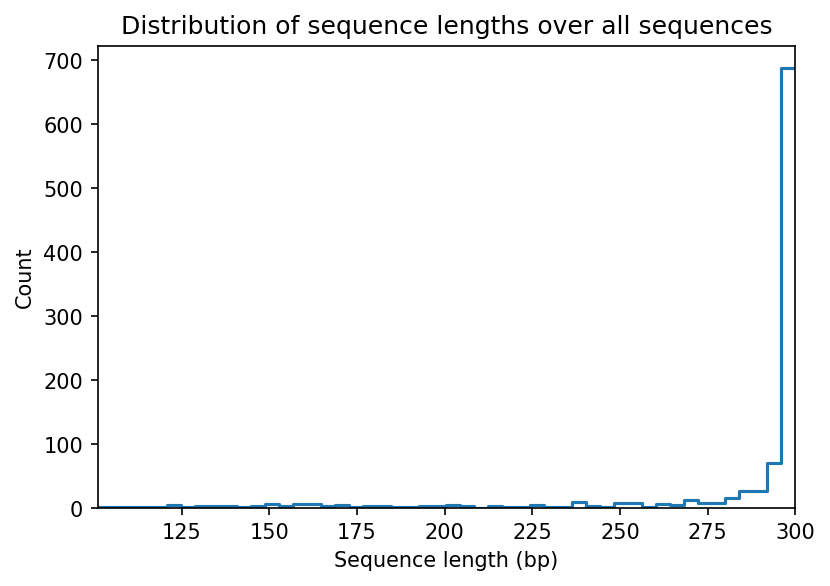

In [ ]:
lens = [len(i) for i in seqs]

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

#sns.kdeplot(lens)
sns.histplot(lens, bins = 50, element="step", fill=False)

ax.set_xlim([min(lens), max(lens)])
ax.set_xlabel('Sequence length (bp)')
ax.set_title('Distribution of sequence lengths over all sequences')